In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# ==============================================================================
# 1. CARREGAMENTO E LIMPEZA INICIAL
# ==============================================================================
# Ajuste o caminho conforme necessário
try:
    df = pd.read_csv(r'..\data\obesity.csv')
except FileNotFoundError:
    # Fallback caso rode na mesma pasta
    df = pd.read_csv('obesity.csv')

print("Dados carregados. Shape inicial:", df.shape)

# --- AJUSTE CRÍTICO: Tratamento de Ruído conforme Dicionário ---
# As variáveis abaixo são escalas (ex: 1 a 3), mas vêm com decimais no CSV (ruído).
# O dicionário instrui explicitamente a arredondar para interpretar a categoria.
cols_to_round = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

for col in cols_to_round:
    # Arredonda para o inteiro mais próximo
    df[col] = df[col].round().astype(int)

print("Arredondamento aplicado nas colunas numéricas com ruído (FCVC, NCP, etc).")

Dados carregados. Shape inicial: (2111, 17)
Arredondamento aplicado nas colunas numéricas com ruído (FCVC, NCP, etc).


In [4]:
# ==============================================================================
# 3. PREPARAÇÃO PARA O MODELO (SPLIT)
# ==============================================================================
X = df.drop('Obesity', axis=1)
y = df['Obesity']

# Stratify é importante aqui para manter a proporção das classes de obesidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dados divididos: {X_train.shape[0]} para treino e {X_test.shape[0]} para teste.")

Dados divididos: 1688 para treino e 423 para teste.


In [5]:
# ==============================================================================
# 4. DEFINIÇÃO DA PIPELINE E PREPROCESSADORES
# ==============================================================================

# Colunas Numéricas
# Nota: FCVC, NCP etc agora são inteiros limpos, mas podem ser tratados como numéricos pelo StandardScaler sem problemas
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Colunas Categóricas Nominais (sem ordem)
one_hot_features = ['Gender', 'family_history', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']

# Colunas Categóricas Ordinais (com ordem específica)
ordinal_features = ['CAEC', 'CALC']

# Definindo a ordem correta das categorias
caec_order = ['no', 'Sometimes', 'Frequently', 'Always'] 
calc_order = ['no', 'Sometimes', 'Frequently', 'Always'] # 'Always' adicionado conforme dicionário

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),   
    ('ordinal_encoder', OrdinalEncoder(categories=[caec_order, calc_order], 
                                       handle_unknown='use_encoded_value', 
                                       unknown_value=-1))
])

one_hot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),       
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor Geral
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_onehot', one_hot_transformer, one_hot_features),
        ('cat_ordinal', ordinal_transformer, ordinal_features)
    ],
    remainder='passthrough'
)

# Pipeline Final
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


Iniciando treinamento...
Modelo treinado com sucesso.

--- Resultados ---
Acurácia no Teste: 0.94

Relatório de Classificação:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.93      0.96        54
      Normal_Weight       0.80      0.88      0.84        58
     Obesity_Type_I       0.97      0.97      0.97        70
    Obesity_Type_II       0.98      0.98      0.98        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.87      0.90      0.88        58
Overweight_Level_II       0.98      0.93      0.96        58

           accuracy                           0.94       423
          macro avg       0.94      0.94      0.94       423
       weighted avg       0.94      0.94      0.94       423



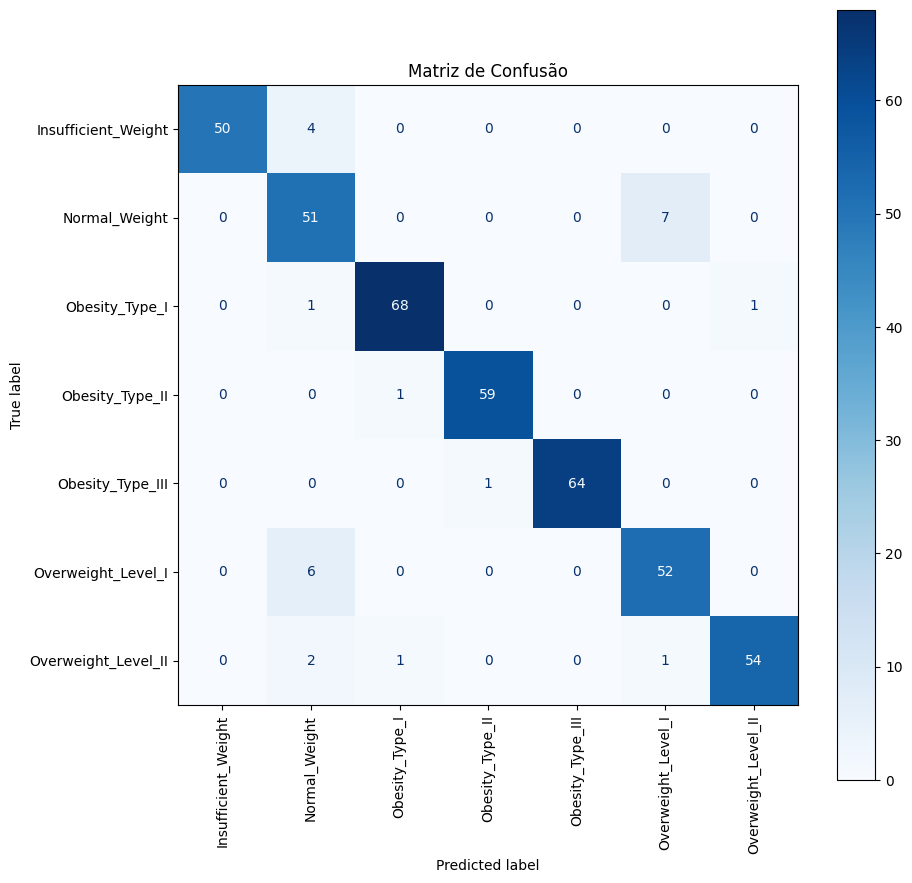


Calculando Cross-Validation (pode demorar um pouco)...
Média da Acurácia (CV): 92.24%
Desvio Padrão (CV): 10.44%


In [6]:
# ==============================================================================
# 5. TREINAMENTO E AVALIAÇÃO
# ==============================================================================
print("\nIniciando treinamento...")
model_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso.")

# Predições
y_pred = model_pipeline.predict(X_test)
accuracy = model_pipeline.score(X_test, y_test)

print(f"\n--- Resultados ---")
print(f"Acurácia no Teste: {accuracy:.2f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred, labels=model_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_pipeline.classes_)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
plt.title('Matriz de Confusão')
plt.show()

# Cross Validation (Opcional, mas recomendado)
print("\nCalculando Cross-Validation (pode demorar um pouco)...")
scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Média da Acurácia (CV): {scores.mean() * 100:.2f}%")
print(f"Desvio Padrão (CV): {scores.std() * 100:.2f}%")

In [7]:
# ==============================================================================
# 6. SALVAR MODELO
# ==============================================================================
save_dir = '../saved_model'
save_path = os.path.join(save_dir, 'modelo_obesidade.joblib')

# Garante que o diretório exista
os.makedirs(save_dir, exist_ok=True) 

joblib.dump(model_pipeline, save_path)
print(f"\nPipeline completa salva com sucesso em: {save_path}")


Pipeline completa salva com sucesso em: ../saved_model\modelo_obesidade.joblib
